## Instructions

- Follow the installation instructions in the readme file
- Answer the questions in this notebook
- Once your work is finished: restart the kernel, run all cells in order and check that the outputs are correct.
- Send your completed notebook to `remy.degenne@inria.fr` with email title `SL_TP1_NAME1_NAME2` (or `SL_TP1_NAME` if you work alone).

**Deadline: Friday, December 8, 11:59 CET**.

If you don't want to use a local installation, you can try Google Colab:

<a target="_blank" href="https://colab.research.google.com/github/RemyDegenne/remydegenne.github.io/blob/master/docs/SL_2023/StoreManagement.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
# This cell is setting up google colab. Ignore it if you work locally.
if 'google.colab' in str(get_ipython()):
  print("Installing packages, please wait a few moments. Restart the runtime after the installation.")
  # install rlberry library
  !pip install scipy rlberry

## Store Management MDP

You own a bike store. During week $t$, the (random) demand is $D_t$ units. 
On Monday morning you may choose to command $A_t$ additional units: they are delivered immediately before the shop opens. For each week:

  * Maintenance cost: $h$ per unit in stock left from the previous week (no maintenance is needed for newly commanded items)
  * Command cost: $c$ for each unit ordered + $c_0$ per command
  * Sales profit: $p$ per unit sold
  * Constraint: 
    - your warehouse has a maximal capacity of $M$ unit (any additionnal bike gets stolen)
    - you cannot sell bikes that you don't have in stock


* State: number of bikes in stock left from the last week => state space $\mathcal{S} = \{0,\dots, M\}$
* Action: number of bikes commanded at the beginning of the week => action space $\mathcal{A} = \{0, \dots ,M\}$ 
* Reward = balance of the week: if you command $a_t$ bikes,
$$r_t = -c_0 \mathbb{1}_{(a_t >0)}- c \times a_t - h\times s_t + p \times \min(D_t, s_t+a_t, M)$$
* Transitions: you end the week with the number of bikes $$s_{t+1} = \max\big(0, \min(M, s_t + a_t)  - D_t \big)$$ 

Our goal is to maximize the discounted sum of rewards, starting from an initial stock $s_1$, that is to find a policy whose value is 
$$V^*(s_1) = \max_{\pi}\mathbb{E}_{\pi}\left[\sum_{s=1}^{\infty} \gamma^{s-1}r_s \right].$$

In [2]:
import numpy as np
import random as rd
import gymnasium as gym
from matplotlib import pyplot as plt
import time 

### Problem parameters 

In [3]:
M = 15 # stock capacity
h = 0.3 # maintenance cost (per unit)
c = 0.5 # ordering cost (per unit)
c0 = 0.3 # fix delivery cost per command
p = 1 # selling price (per unit)

### Specifying the demand distribution 

As an example of demand distribution, we choose a (truncated) geometric distribution, for which 
$$\mathbb{P}(D_t = m) = q(1-q)^m \ \ \forall m \in \{0,\dots,M-1\}$$
and $\mathbb{P}(D_t = M) = 1 - \sum_{m=0}^{M-1}\mathbb{P}(D_t = m)$. We provide below a function that simulate the demand. 

In [4]:
# demand distribution (truncated geometric with parameter q)
q = 0.1
pdem = np.array([q*(1-q)**m for m in range(M+1)])
pdem[M] = pdem[M]+1-np.sum(pdem)

print("the average demand is ",np.sum([m*pdem[m] for m in range(M+1)]))

def SimuDemand(pdem): 
    cpdem = np.cumsum(pdem)
    i=0
    u = rd.random()
    while (u >cpdem[i]):
        i = i+1
    return i 

print("a simulated demand is ",SimuDemand(pdem))

the average demand is  7.1469798111481575
a simulated demand is  7


In [5]:
pdem

array([0.1       , 0.09      , 0.081     , 0.0729    , 0.06561   ,
       0.059049  , 0.0531441 , 0.04782969, 0.04304672, 0.03874205,
       0.03486784, 0.03138106, 0.02824295, 0.02541866, 0.02287679,
       0.20589113])

### Encoding the MDP as a gymnasium environment

This is just a  toy example on how to create a gymnasium environement. 

Note that our environement is an example of tabular MDP for which the transition probabilities $P(s'|s,a)$ and the mean rewards $r(s,a)$ can actually be computed in closed form. Therefore we provide the transitions $(P)$ and mean rewards $(r)$ as attributes of the class. 

In [6]:
def nextstate(s,a,d,M):
    # computes the next state if the demand is d
    return max(0,min(M,s+a) -d)

def nextreward(s,a,d,M,c,c0,h,p):
    # computes the reward if the demand is d
    rew = -c*a - h*s + p*min(M,d,s+a)
    if (a>0):
        rew = rew - c0
    return rew

class StoreManagement(gym.Env):
    """
    Retail Store Management environment
    The environment defines which actions can be taken at which point and
    when the agent receives which reward.
    """
    def __init__(self,FirstState,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1):
        
        # General variables defining the environment
        self.Stock_Capacity = M
        self.Maintenance_Cost = h
        self.Order_Cost = c 
        self.Delivery_Cost = c0
        self.Selling_Price = p
        pdem = np.array([q*(1-q)**m for m in range(M+1)])
        pdem[M] = pdem[M]+1-np.sum(pdem)
        self.Demand_Distribution = pdem
        
        # Define the action space
        self.action_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # Define the state space (state space = observation space in this example)
        self.observation_space = gym.spaces.Discrete(self.Stock_Capacity+1)

        # current time step
        self.curr_step = -1 # 
        
        # initial state
        self.state = FirstState

        # computation of the MDP parameters
        P = np.zeros((M+1,M+1,M+1)) # P[s,a,s'] = p(s' | s,a) 
        r = np.zeros((M+1,M+1)) # r[s,a] = average reward received in state s when playing action a
        ## iteration over all possible states, actions, and possible demand values
        for a in range(M+1):
            for s in range(M+1):
                for d in range(M+1):
                    # next state and reward with demand d
                    ns = max(0,min(M,s+a) -d)
                    reward = -c*a - h*s+p*min(M,d,s+a)
                    if (a>0):
                        reward = reward - c0
                    P[s,a,ns] += pdem[d]
                    r[s,a] += pdem[d] * reward
        self.P = P # P[s,a,ns] = P(ns | s,a)
        self.r = r # r[s,a] = r(s,a)

    def step(self, action):
        """
        simulates a transition following an action in the current state
        action : int
        """
        self.curr_step += 1
        # simulate the demand 
        Demand = SimuDemand(self.Demand_Distribution)
        # compute the reward
        reward = nextreward(self.state,action,Demand,self.Stock_Capacity,self.Order_Cost,self.Delivery_Cost,self.Maintenance_Cost,self.Selling_Price)
        # compute the next state 
        self.state = nextstate(self.state,action,Demand,self.Stock_Capacity)
        # return 4 elements: observation / reward / termination? / truncation ? / information  
        return self.state, reward, False, False,{}

    def reset(self,InitialStock):
        """
        Reset the state of the environment and returns an initial observation.
        """
        self.curr_step = -1
        self.state = InitialStock
    
    def _render(self, mode='human'):
        """optional visualization of the interaction: none here"""
        return


### A function that simulates a trajectory under a policy Pi starting from some state $s_0$

**Complete the function below to simulate a trajectory of length $T$ from an initial state $s_0$ under a policy Pi**

Write a function `SimulateTrajectory` that takes 3 arguments T, Pi and s0. It should initialize a StoreManagement environment in the state s0. Then, for T steps, will will:
- query the state of the environment
- choose an action according to the policy
- get a new state and a reward by calling `state, reward, _, _, _ = env.step(action)` (where `env` is the environment)

The function should return two arrays of length `T`: one for the states visited and one for the rewards obtained.

In [7]:
def SimulateTrajectory(T,Pi,s0):
    """return a vector of T successive states and a vector of T successive rewards"""
    Rewards = np.zeros(T)
    States = np.zeros(T)
    env=StoreManagement(s0)
    for t in range(T):
        States[t] = env.state
        action = Pi(env.state)
        next_state, reward, _,_,_ = env.step(action)
        Rewards[t] = reward
    return States, Rewards

### Running simulations with three simple baselines 

In [8]:
s1 = 10 # initial stock 
gamma = 0.97 # discount factor 

def PiUniform(s):
    # pick uniformly at random in {0,1,...,M-s}
    x = rd.sample(range(M+1-s),1)
    return s+x[0]

def PiConstant(s,c=3):
    # oder a constant number of c bikes 
    return min(c,M-s)

def PiThreshold(s,m1=4,m2=10):
    # if less than m1 bikes in stock, refill it up to m2
    action = 0
    if (s <=m1):
        action = (m2-s)
    return action

**Plot the cumulative discounted reward as a function of time for the three baselines.**

You should plot one trajectory for each policy, all on the same graph. Don't forget to add legends to the graph.

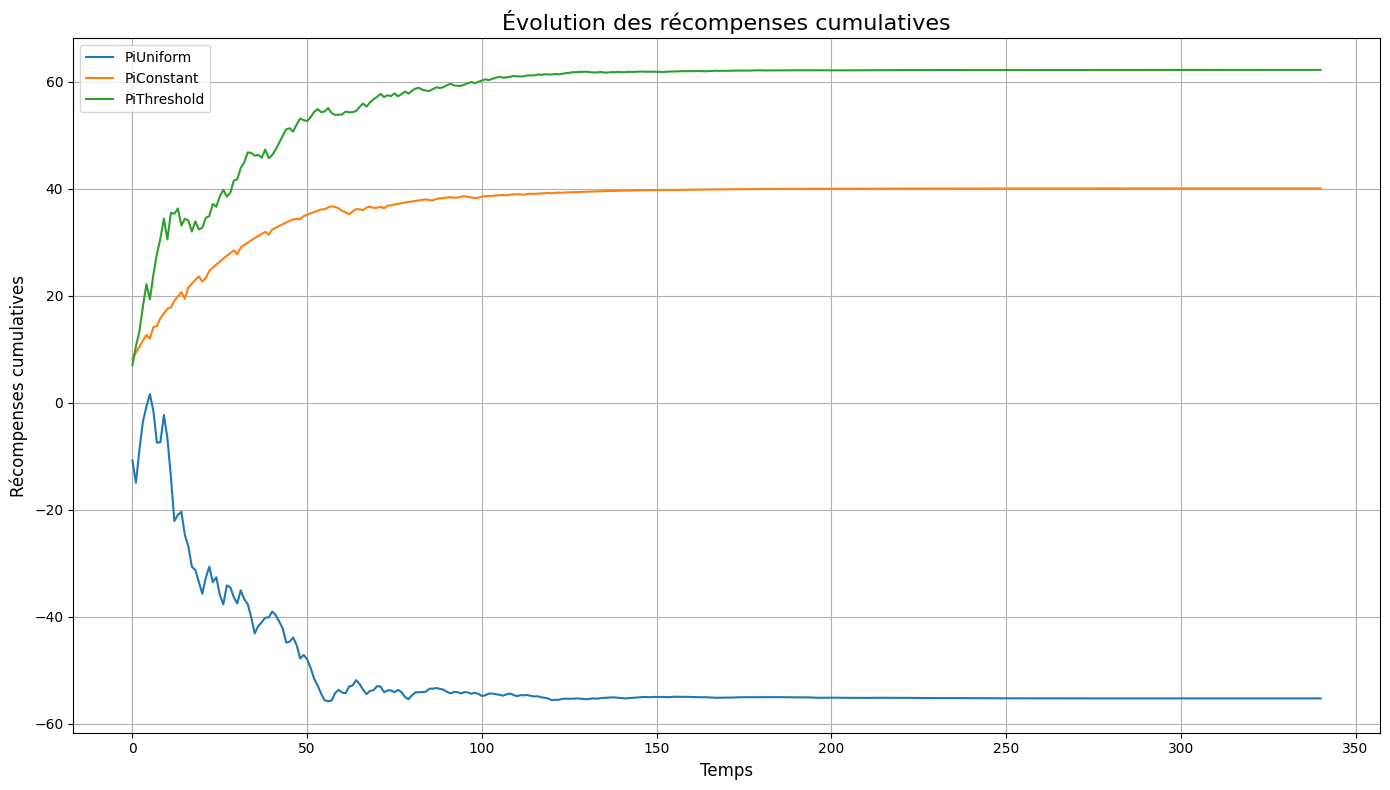

In [9]:
T = int(np.log(1/(0.001*(1-gamma)))/np.log(1/gamma)) # truncation of the infinite sum

policies = [PiUniform, PiConstant, PiThreshold]
plt.figure(figsize=(14,8))
for policy in policies:
    States, Rewards = SimulateTrajectory(T,policy, s1)
    cumulative_rewards = []
    cum_reward = 0
    for t in range(T):
        cum_reward += gamma**(t)*Rewards[t] 
        cumulative_rewards.append(cum_reward)
    plt.plot(range(T),cumulative_rewards,  label=f'{policy.__name__}')
plt.title('Évolution des récompenses cumulatives', fontsize=16)  
plt.xlabel('Temps', fontsize=12)  
plt.ylabel('Récompenses cumulatives', fontsize=12)
plt.legend()
plt.grid(True)  
plt.tick_params(axis='both', which='major', labelsize=10) 
plt.tight_layout() 
plt.show()


De manière intuitive on observe que la policy uniform converge vers une reward négative. A l'inverse la policy constante réussi à converger vers une récompense cumulative positive mais performe moins bien que la policy threhold qui s'adapte à la situation

### Evolution of the stock

Text(0.5, 1.0, 'Evolution of the stock under a threshold policy')

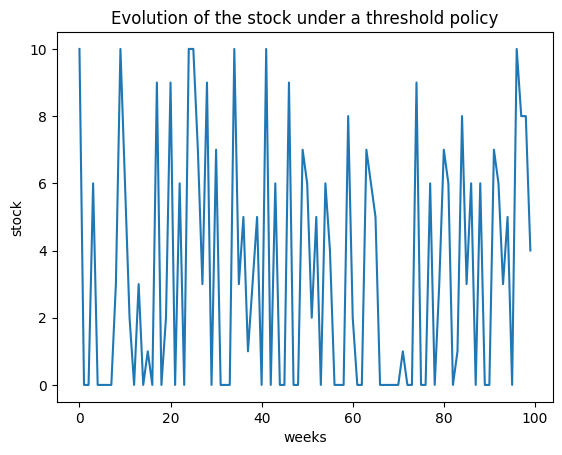

In [10]:
States, Rewards = SimulateTrajectory(T,PiThreshold, s1)
plt.figure()
plt.plot(States[range(100)])
plt.xlabel('weeks')
plt.ylabel('stock')
plt.title('Evolution of the stock under a threshold policy')

# Dynamic Programming

So far, when doing simulations, we just interacted with the environements with calls to the "step" functions (which boils down to simulating the demand each week). However, we assume that all the parameters (including the demand distribution itself, paramterized by $q$) are known, we can evaluate policies, and compute the optimal policy using the knowledge of the MDP parameters (encoded in env.P and env.r).

In [11]:
env = StoreManagement(0,M=15,h=0.3,c=0.5,c0=0.3,p=1,q=0.1)

# MDP parameters
P = env.P # P[s,a,s'] = p(s' | s,a) 
r = env.r # r[s,a] = average reward received in state s when playing action a

In [12]:
P.shape, r.shape

((16, 16, 16), (16, 16))

## Evaluation of deterministic policies

**Evalute a policy of your choice using Monte-Carlo simulation, i.e. compute the value of this policy in all states.** 

In a Monte-Carlo simulation to estimate the value of $V^\pi(s)$, we collect `MC` values for the sum of discounted rewards over long enough trajectories starting at $s$, then compute the mean of these `MC` values.
We need to compute trajectories from *all* states.

Observe that we do *not* need the knowledge of $P$ and $r$ for this method, simulating trajectories is enough.

In [13]:
def cum_rewards(Rewards):
    T = len(Rewards)
    cumulative_rewards = []
    cum_reward = 0
    for t in range(T):
        cum_reward += gamma**(t)*Rewards[t] 
        cumulative_rewards.append(cum_reward)
    return cumulative_rewards[-1]

In [14]:
## Computes the values in each state by Monte-Carlo simulation (needs many simulations to be precise)

Policy = PiThreshold

MC = 100 # number of Monte-Carlo simulations
Values = np.zeros(M+1)

for initial_state in range(len(Values)):
    rewards_from_state = []
    for _ in range (MC):
        States, Rewards = SimulateTrajectory(T,policy, initial_state)
        rewards_from_state.append(cum_rewards(Rewards))
    Values[initial_state] = np.mean(rewards_from_state)

print("the estimated value in each states for the threshold policy are:")

print(Values)
    

the estimated value in each states for the threshold policy are:
[49.07154049 48.4679923  47.53923654 48.425324   48.71207979 49.26743164
 50.01060823 49.22736314 49.3866593  49.37287247 51.55513083 49.41048658
 51.304939   51.48133498 53.9013257  49.18853019]


In [15]:
print(f"Ideal initial state based on MC simulations is having {np.argmax(Values)} bikes in stock")

Ideal initial state based on MC simulations is having 14 bikes in stock


**Implement a function that evaluates a deterministic policy Pi using the matrix inversion technique. Compare the output with the previous method for the same policy.**

Unlike the previous evaluation method, this one requires the knowledge of $P$ and $r$. 

In [16]:
def EvaluatePolicy(Pi):
    # input: function (could also be vector as we can only use this method for deterministic policies)
    p_pi = np.zeros((M+1,M+1))
    r_pi = np.zeros(M+1)
    for state in range(M+1):
        action = Pi(state)
        probas = P[state,action]
        p_pi[state] = probas
        r_pi[state] = r[state, action]

    

    V_pi = np.linalg.inv(np.eye(M+1)-gamma*p_pi)@r_pi
    return V_pi
    # should return a vector of values

Policy = PiThreshold
Values = EvaluatePolicy(Policy)

print(Values)

[48.73499347 48.93499347 49.13499347 49.33499347 49.53499347 49.71122352
 50.04440882 50.34326461 50.60790492 50.83844345 51.03499347 51.19766791
 51.32657931 51.42183984 51.48356131 51.51185512]


**Evaluate two different policies and visualize their values for the different states in order to decide which one is better.** 

In [17]:
Values_Thr = EvaluatePolicy(PiThreshold)
Values_cst = EvaluatePolicy(PiConstant)
for state in range(M+1):
    print(f'In state {state} Threshold policy value {np.round(Values_Thr[state],2)} vs Cst policy value {np.round(Values_cst[state],2)}')

In state 0 Threshold policy value 48.73 vs Cst policy value 29.6
In state 1 Threshold policy value 48.93 vs Cst policy value 30.1
In state 2 Threshold policy value 49.13 vs Cst policy value 30.54
In state 3 Threshold policy value 49.33 vs Cst policy value 30.93
In state 4 Threshold policy value 49.53 vs Cst policy value 31.27
In state 5 Threshold policy value 49.71 vs Cst policy value 31.57
In state 6 Threshold policy value 50.04 vs Cst policy value 31.81
In state 7 Threshold policy value 50.34 vs Cst policy value 32.01
In state 8 Threshold policy value 50.61 vs Cst policy value 32.17
In state 9 Threshold policy value 50.84 vs Cst policy value 32.29
In state 10 Threshold policy value 51.03 vs Cst policy value 32.39
In state 11 Threshold policy value 51.2 vs Cst policy value 32.47
In state 12 Threshold policy value 51.33 vs Cst policy value 32.56
In state 13 Threshold policy value 51.42 vs Cst policy value 32.76
In state 14 Threshold policy value 51.48 vs Cst policy value 32.96
In state

La policy threshold est nettement meilleur que la policy constante ce qui est logique étant donné que choisir une action constante ne permet pas de s'adapter 

## Computing the Optimal Policy: Policy Iteration 

The function given below performs policy improvement, and may be useful to implement both value iteration and policy iteration. Note that the (deterministic) policy it outputs is encoded as a vector, not a function. 


In [18]:
# policy improvement
def Improve(V):
    '''computes the Q table associated to V and 
    return Pi=greedy(V)=greedy(Q) as well as max_{a} Q[s,a]'''
    Pi = np.zeros(M+1) # improved policy 
    newV = np.zeros(M+1)
    # compute the Q table 
    Q = np.zeros((M+1,M+1))
    for s in range(M+1):
        for a in range(M+1):
            Q[s,a]=r[s,a]+gamma*np.sum([P[s,a,ns]*V[ns] for ns in range(M+1)])
        # improvement (greedy policy wrt to Q)
        pi = np.argmax(Q[s,:])
        Pi[s]=pi
        newV[s]=Q[s,pi]
        Pi=Pi.astype(int)
    return Pi,newV


V = np.random.randint(M+1,size=M+1) 
newPi,newV = Improve(V)
print("improved policy from random:",newPi)

improved policy from random: [10  9  8  7  6  5  4  3  2  1  0  0  0  0  0  0]


In [19]:
newV

array([ 8.37948897,  8.57948897,  8.77948897,  8.97948897,  9.17948897,
        9.37948897,  9.57948897,  9.77948897,  9.97948897, 10.17948897,
       10.67948897, 10.39654007, 10.11188606, 10.40769746, 10.06192771,
        9.52673494])

**Implement Value Iteration and Policy Iteration.**

First, check that the two algorithms output the same optimal policy. Then, you may compare the number of iteration needed by both algorithms as well as the executation time. 

In [60]:
def T_opt(V):
    V_opt = []
    Pi_greedy = []
    for s in range(M+1):
        # We Compute Q values
        Q = r[s] + gamma*P[s]@V
        # We determine the optimal value given a state
        V_opt.append(max(Q))
        # We identify the optimal action in that state
        Pi_greedy.append(np.argmax(Q)) 
    return V_opt, Pi_greedy

In [57]:
def EvaluatePolicy_matrix(Pi):
    p_pi = np.zeros((M+1,M+1))
    r_pi = np.zeros(M+1)
    for state in range(M+1):
        action = Pi[state]
        probas = P[state,action]
        p_pi[state] = probas
        r_pi[state] = r[state, action]
    V_pi = np.linalg.inv(np.eye(M+1)-gamma*p_pi)@r_pi
    return V_pi

In [47]:
def ValueIteration(epsilon=1e-3): # epsilon = guaranteed precision
    V0 = np.random.randint(M+1,size=M+1) 
    V= V0
    V_new, Pi_greedy = T_opt(V)
    n_iter = 0
    while np.linalg.norm(np.array(V)-np.array(V_new))>= epsilon:
        V_intermed, Pi_greedy = T_opt(V_new)
        V_new, V = V_intermed, V_new
        n_iter += 1

    return Pi_greedy, V_new, n_iter

In [76]:
def PolicyIteration():
    Pi_1 = np.random.randint(M+1,size=M+1) 
    Pi_2 = None
    n_iter = 0
    while (Pi_1 != Pi_2).any():
        Pi_2 = Pi_1
        V_pi_1 = EvaluatePolicy_matrix(Pi_1)
        Pi_1 , newV= Improve(V_pi_1)
        n_iter += 1

    return Pi_1, V_pi_1, n_iter

In [79]:

start = time.time()
Pi,V,nIt = ValueIteration()
elapsed_1 = time.time()-start

start = time.time()
Pi2,V2,nIt2 = PolicyIteration()
elapsed_2 = time.time()-start

print("Value iteration yields policy",Pi,"and value ",V," in ",nIt," iterations and t=",np.round(elapsed_1,4)," seconds\n")
print("Optimal policy is",Pi2,"with value ",V2," in ",nIt2," iterations and t=",np.round(elapsed_2,4)," seconds")


Value iteration yields policy [9, 8, 7, 6, 5, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] and value  [48.86063186531906, 49.06063186531905, 49.260631865319056, 49.46063186531906, 49.660631865319054, 49.86063186531906, 50.16790392533418, 50.46632269857817, 50.7305274559642, 50.96063186531906, 51.156749216835514, 51.318992424327, 51.44747402647799, 51.54230618809027, 51.6036007013251, 51.631468986941215]  in  277  iterations and t= 0.3276  seconds

Optimal policy is [9 8 7 6 5 4 0 0 0 0 0 0 0 0 0 0] with value  [48.86867719 49.06867719 49.26867719 49.46867719 49.66867719 49.86867719
 50.17594925 50.47436803 50.73857278 50.96867719 51.16479455 51.32703775
 51.45551935 51.55035152 51.61164603 51.63951432]  in  4  iterations and t= 0.102  seconds


Both methods give the same optimal policy as expected, we can notice however that policy iteration converges in only 3 iterations and is about 3 times faster than Value Iteration.

Here is a visualization of the optimal policy. 

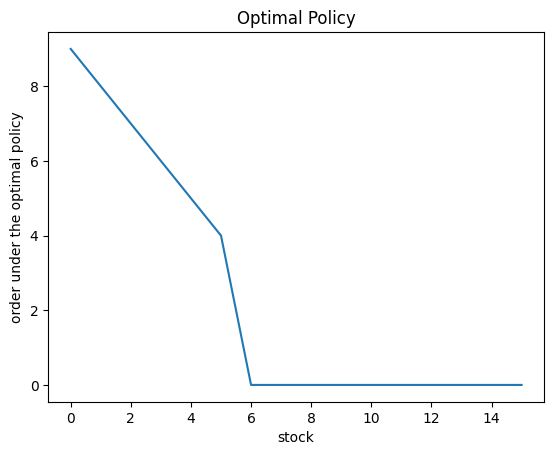

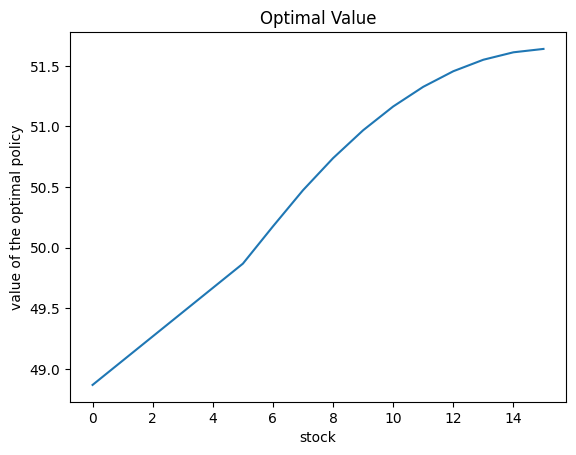

In [80]:
plt.plot(Pi2)
plt.xlabel('stock')
plt.ylabel('order under the optimal policy')
plt.title("Optimal Policy")

plt.figure()
plt.plot(V2)
plt.xlabel('stock')
plt.ylabel('value of the optimal policy')
plt.title("Optimal Value")

Vstar=np.copy(V)

We notice that the optimal policy reduces the number of orders and reaches progressively 0 orders as the stock increases, which makes sense since the more stock we already have, the less we need to order bikes in the beginning of the week.
On the other hand the optimal value increases as our initial stock increases, which also makes sense since the goal is to maximize our profit by selling bikes and therefore it seems that with the specified probabilities, there's a pretty high demand in general which would explain why we would want to have high initial stocks.